# Getting Ualong in the X and Y grid

In [1]:
# # Compute monthly ASC along contour and save



import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import sys,os
from dask.distributed import Client

#import xarray.ufuncs as xu
import xgcm

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)


from dask.distributed import Client
client = Client(n_workers=112)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 112
Total threads: 112,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42701,Workers: 112
Dashboard: /proxy/8787/status,Total threads: 112
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:44157,Total threads: 1
Dashboard: /proxy/38519/status,Memory: 2.23 GiB
Nanny: tcp://127.0.0.1:36019,


In [2]:
#Drawing the grid (example in the westernmost edge
                  
#
#   Legend:
#   o = u,v
#   x = tx, ty transport
#   t = Tracer grid (t,n)  
#
#
#
#         ty transport (-279.95,-81.09)
#           ^
#           | 
#   -------(+)------o=(u,v)(-279.90,-81.09)
#  |                |   
#  |                |
#  |                |
#  |       (t)     (+)--> Tx transport (-279.90,-81.11)
#  |                |
#  |                |
#  |                |
#   ----------------

In [3]:
	# Load database
	#DO NOT FORGET TO SET THE EXPERIMENT NAME (EXPT) AND TO ALTER LINES [44,51] AND [103,113]
	session = cc.database.create_session()
	# Define experiment in database
	expt = '01deg_jra55v13_ryf9091'
	
	#expt0 = '01deg_jra55v140_iaf' #Line below only necessary for iaf. if ryf repeat name
	
	lat_slice = slice(-80, -59)
	
	# Import bathymetry
	hu = cc.querying.getvar(expt, 'hu', session, n=1)
	
	# Import grid cell length
	dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
	dyu = cc.querying.getvar(expt, 'dyu', session, n=1)
	
	##THis part below doesnt need to be run for IAF experiments, BUT SHOULD BE UNCOMMENTED FOR RYF EXPERIMENTS  
	## Change coordinate name
	dxu.coords['ni'] = hu['xu_ocean'].values
	dxu.coords['nj'] = hu['yu_ocean'].values
	dyu.coords['ni'] = hu['xu_ocean'].values
	dyu.coords['nj'] = hu['yu_ocean'].values
	dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
	dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
	
	# Select latitude range
	hu = hu.sel(yu_ocean=lat_slice)
	hu = hu.load()
	dxu = dxu.sel(yu_ocean=lat_slice)
	dxu = dxu.load()
	dyu = dyu.sel(yu_ocean=lat_slice)
	dyu = dyu.load()
	
	# Load model grid information
	path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
	grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

	ds = xr.merge([hu, grid])
	ds.coords['xt_ocean'].attrs.update(axis='X')
	ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
	ds.coords['yt_ocean'].attrs.update(axis='Y')
	ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
	
	grid = xgcm.Grid(ds, periodic=['X'])
	
	# Take gradient and move to u grid
	# Simple gradient over one grid cell. 
	# In latitudinal direction, we need to specify what happens at the boundary.
	dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
	dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')
	
	# Same as: (other option)
	#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
	#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu
	
	# Select latitude slice
	dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
	dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)
	
	# Calculate the magnitude of the topographic slope
	slope = (dhu_dx**2 + dhu_dy**2)**0.5 #before it was : xu.sqrt(dhu_dx**2 + dhu_dy**2)
	
	

In [4]:
Slopedata=xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/slope1000m.nc') 
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([Slopedata.slope, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([Slopedata.slope, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
slope_xg=gridx.interp(dsx.slope, 'Y').isel(yt_ocean=slice(0,484))
slope_yg=gridx.interp(dsx.slope, 'X').isel(yu_ocean=slice(0,484))
    


In [5]:
#Interpolating the slope into the x and y grids
x_s=slope.xu_ocean
y_s=slope.yu_ocean
import xgcm
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

dsx = xr.merge([Slopedata.dhu_dy,Slopedata.dhu_dx, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([Slopedata.dhu_dy,Slopedata.dhu_dx, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
dhu_dy_xg=gridx.interp(dsx.dhu_dy, 'Y').isel(yt_ocean=slice(0,484))
dhu_dy_yg=gridx.interp(dsx.dhu_dy, 'X').isel(yu_ocean=slice(0,484))
dhu_dx_xg=gridx.interp(dsx.dhu_dx, 'Y').isel(yt_ocean=slice(0,484))
dhu_dx_yg=gridx.interp(dsx.dhu_dx, 'X').isel(yu_ocean=slice(0,484))

### Importing u,v data to transpose it to (a,c) space

In [6]:
	# Load velocity data
	#yearinit=2177
	yearinit = 2080
	monthseries=['01','02','03','04','05','06','07','08','09','10','11','12']
	mi=0
	isobath_depth = 1000
	test = np.int(yearinit)+1
#	print(test)  
# 	print('isobath depth is ' + str(isobath_depth) + ' m')
	for n in np.arange(0,1): 
		start_time=str(yearinit) + '-' + monthseries[n]
		if n <= 10:
		    end_time=str(yearinit) + '-' + monthseries[n+1]
		    
		if n >= 11:   
		    end_time=str(np.int(yearinit)+1) + '-01'
		
		
		print(end_time)
#		if n >= 10:
#		    end_time=str(int(np.int((yearinit)+1)) + '-01'
#		    print(str(n))        
#		
#		
#		     end_time=str(yearinit) + '-' + monthseries[n+1]       
#		else:
#		    end_time=str(int(np.int((yearinit)+1)) + '-01'
#		
#		print('End time is ' + end_time)
#		
		u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
		u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).isel(time=0)
		v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, ncfile="ocean.nc")
		v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).isel(time=0)
		

2080-02


now converting the u and v to x and y grids...

In [7]:
#Interpolating u
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsx = xr.merge([u, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([u, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
u_xg=gridx.interp(dsx.u, 'Y').isel(yt_ocean=slice(0,484))
u_yg=gridx.interp(dsy.u, 'X').isel(yu_ocean=slice(0,484))

In [8]:
#Interpolating v
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsx = xr.merge([v, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([v, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
v_xg=gridx.interp(dsx.v, 'Y').isel(yt_ocean=slice(0,484))
v_yg=gridx.interp(dsy.v, 'X').isel(yu_ocean=slice(0,484))

### Calculating uxg_along and uyg_along

In [9]:
		# Along-slope velocity
		Uxg_along = u_xg*dhu_dy_xg/slope_xg - v_xg*dhu_dx_xg/slope_xg
		Uyg_along = u_yg*dhu_dy_yg/slope_yg - v_yg*dhu_dx_yg/slope_yg
		# Cross-slope velocity
		Vxg_cross = u_xg*dhu_dy_xg/slope_xg - v_xg*dhu_dx_xg/slope_xg
		Vyg_cross = u_yg*dhu_dy_yg/slope_yg - v_yg*dhu_dx_yg/slope_yg

In [10]:
		# import edges of st_ocean and add lat/lon dimensions:
		st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
		st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])
		
		# adjust edges at bottom for partial thickness:
		st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
		thickness = st_edges_with_partial.diff(dim='st_edges_ocean')
		
		# change coordinate of thickness to st_ocean (needed for multipling with other variables):
		st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
		thickness['st_edges_ocean'] = st_ocean.values
		thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
		thickness = thickness

We will also need to interpolate the thickness

In [63]:
#Interpolating u
gridx = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsx = xr.merge([thickness, gridx])
dsx.coords['xt_ocean'].attrs.update(axis='X')
dsx.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsx.coords['yt_ocean'].attrs.update(axis='Y')
dsx.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridx = xgcm.Grid(dsx, periodic=['X'])


#y
gridy = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
dsy = xr.merge([thickness, gridy])
dsy.coords['xt_ocean'].attrs.update(axis='X')
dsy.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
dsy.coords['yt_ocean'].attrs.update(axis='Y')
dsy.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

gridy = xgcm.Grid(dsy, periodic=['X'])

# Calculating the slope on the x and y grid
thickness_xg=gridx.interp(dsx.st_edges_ocean, 'Y').isel(yt_ocean=slice(0,484))
thickness_yg=gridx.interp(dsy.st_edges_ocean, 'X').isel(yu_ocean=slice(0,484))

## Importing 1000m depth contour on x,y grid

In [11]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']


#cutting the matrices
ylength= np.shape(mask_x_transport)[0]


yt_ocean0 = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
yu_ocean0 = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
xt_ocean0 = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean0 = cc.querying.getvar(expt,'xu_ocean',session,n=1)





In [12]:
mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="yt_ocean",dim_1="xu_ocean")
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="yu_ocean",dim_1="xt_ocean")
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

In [13]:
num_points

6002

In [14]:
	lat_along_contour = np.zeros((num_points))
	lon_along_contour = np.zeros((num_points))
	# locations for zonal transport:
	x_indices_masked = mask_x_transport_numbered.stack().values
	x_indices = np.sort(x_indices_masked[x_indices_masked>0])
	for count in x_indices:
	    count = int(count)
	    jj = int(np.where(mask_x_transport_numbered==count)[0])
	    ii = int(np.where(mask_x_transport_numbered==count)[1])   
	    lon_along_contour[count-1] = xu_ocean0[ii].values
	    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
	    
	# locations for meridional transport:
	y_indices_masked = mask_y_transport_numbered.stack().values
	y_indices = np.sort(y_indices_masked[y_indices_masked>0])
	for count in y_indices:
	    count = int(count)
	    jj = np.where(mask_y_transport_numbered==count)[0]
	    ii = np.where(mask_y_transport_numbered==count)[1]
	    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
	    lat_along_contour[count-1] = yu_ocean0[jj].values
	

Notice that the code below has a line that substitutes indices (jj>483 to 483). Tha tis beacsue the matricces are cur slightly odd. I added that like as a easy fast fix but alter on I will need to make sure the matrices are correctly cut

In [18]:
import warnings

warnings.filterwarnings('ignore')


Uyg_along0=Uyg_along.load()
Uxg_along0=Uxg_along.load()

### Getting values along the contour


In [42]:
from joblib import Parallel, delayed
def contour_extractor(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,Uxg_along0,Uyg_along0, nz):  
    #U_along_slope_z= np.zeros((75,num_points))
    U_along_slope = np.zeros((num_points))
    for count in x_indices:
        count = int(count)
        jj = int(np.where(mask_x_transport_numbered==count)[0])
        ii = int(np.where(mask_x_transport_numbered==count)[1])
        if jj>483: jj=483
        U_along_slope[count-1] += Uxg_along0[nz,jj,ii]
    # locations for meridional transport, already calculated indices above:
    for count in y_indices:
        count = int(count)
        jj = int(np.where(mask_y_transport_numbered==count)[0])
        ii = int(np.where(mask_y_transport_numbered==count)[1])
        if jj>483: jj=483
        U_along_slope[count-1] += Uyg_along0[nz,jj,ii]
    return U_along_slope
    #U_along_slope_z[nz,:]=U_along_slope
    #vary_full=np.array(Ftemp_cross_contour_xyg)

In [43]:
%%time
del results
results = Parallel(n_jobs=-1)(delayed(contour_extractor)(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,Uxg_along0,Uyg_along0, nz) for nz in range(75))



CPU times: user 1min 30s, sys: 1min 6s, total: 2min 37s
Wall time: 4min 47s


In [44]:
U_along_slope_z=results

In [52]:
############################ Cross-slope velocity       
Vyg_cross0=Vyg_cross.load()
Vxg_cross0=Vxg_cross.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [58]:
		from joblib import Parallel, delayed
		def contour_extractor(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,Vxg_cross0,Vyg_cross0, nz):  
		    #U_along_slope_z= np.zeros((75,num_points))
		    U_along_slope = np.zeros((num_points))
		    V_cross_slope = np.zeros((num_points))
		    for count in x_indices:
		        count = int(count)
		        jj = int(np.where(mask_x_transport_numbered==count)[0])
		        ii = int(np.where(mask_x_transport_numbered==count)[1])
		        if jj>483: jj=483
		        V_cross_slope[count-1] += Vxg_cross0[nz,jj,ii]                
		    # locations for meridional transport, already calculated indices above:
		    for count in y_indices:
		        count = int(count)
		        jj = int(np.where(mask_y_transport_numbered==count)[0])
		        ii = int(np.where(mask_y_transport_numbered==count)[1])
		        if jj>483: jj=483
		        V_cross_slope[count-1] += Vyg_cross0[nz,jj,ii] 
		    return V_cross_slope

In [59]:
		results = Parallel(n_jobs=-1)(delayed(contour_extractor)(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,Uxg_along0,Uyg_along0, nz) for nz in range(75))
		V_cross_slope_z=results        

Now for the thickness

In [69]:
############################ Loading thicknesses     
thickness_yg0=thickness_yg.load()
thickness_xg0=thickness_xg.load()

In [71]:
		from joblib import Parallel, delayed
		def contour_extractor(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,thickness_yg0,thickness_xg0, nz):  
		    thickness_slope = np.zeros((num_points))
		    for count in x_indices:
		        count = int(count)
		        jj = int(np.where(mask_x_transport_numbered==count)[0])
		        ii = int(np.where(mask_x_transport_numbered==count)[1])
		        if jj>483: jj=483
		        thickness_slope[count-1] += thickness_xg0[nz,jj,ii]                
		    # locations for meridional transport, already calculated indices above:
		    for count in y_indices:
		        count = int(count)
		        jj = int(np.where(mask_y_transport_numbered==count)[0])
		        ii = int(np.where(mask_y_transport_numbered==count)[1])
		        if jj>483: jj=483
		        thickness_slope[count-1] += thickness_yg0[nz,jj,ii] 
		    return thickness_slope

In [72]:
		del results
		results = Parallel(n_jobs=-1)(delayed(contour_extractor)(num_points,mask_y_transport_numbered,mask_x_transport_numbered,x_indices,Uxg_along0,Uyg_along0, nz) for nz in range(75))
		thickness_slope_z=results    

## Visual checking

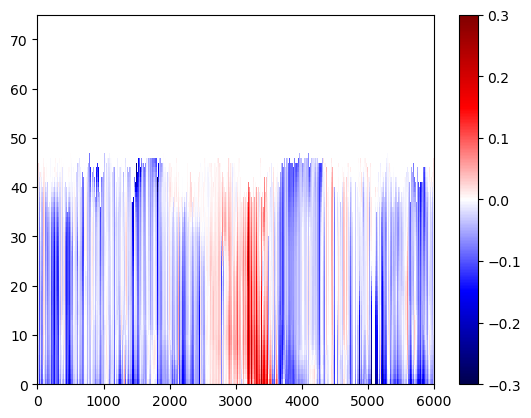

In [73]:
plt.pcolormesh(U_along_slope_z,vmin=-0.3, vmax=0.3,cmap='seismic')
plt.colorbar()

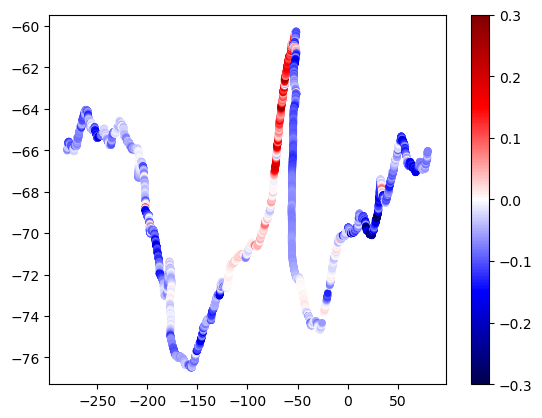

In [48]:
plt.scatter(lon_along_contour,lat_along_contour,s=20, c=U_along_slope_z[0],cmap='seismic',vmin=-0.3,vmax=0.3)
plt.colorbar()

ok, the code seems to be working prorperly. Lets create a python script and run it monthly on the queue

### Saving

In [83]:
#we  will need distance along the contour
import geopy.distance

distance_along_contour=np.ones(num_points)
for n in range(num_points-1):
    coords_1 = (lat_along_contour[n], lon_along_contour[n])
    coords_2 = (lat_along_contour[n+1], lon_along_contour[n+1])
    distance_along_contour[n]=geopy.distance.geodesic(coords_1, coords_2).km

    
#for the last casE CORNER
coords_1 = (lat_along_contour[-1], lon_along_contour[-1])
coords_2 = (lat_along_contour[0], lon_along_contour[0])
distance_along_contour[num_points-1]=geopy.distance.geodesic(coords_1, coords_2).km

distance_along_contour=np.cumsum(distance_along_contour)

In [85]:
		#testing saving in a random dir
		# PREVIOUS SAVEDIR TO LOCATE THE FILES save_dir  = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/'
		save_dir  = '/g/data/x77/wf4500/ASC_project/' 
		file_name = 'Antarctic_slope_contour_1km_velocities_'
		
		data_u=xr.DataArray((U_along_slope_z),name="u_along_contour",dims=["st_ocean","distance_along_contour"])
		data_v=xr.DataArray((V_cross_slope_z),name="v_cross_contour",dims=["st_ocean","distance_along_contour"])
		data_lon=xr.DataArray((lon_along_contour),name="lon_along_contour",dims=["distance_along_contour"])
		data_lat=xr.DataArray((lat_along_contour),name="lat_along_contour",dims=["distance_along_contour"])
		data_thick=xr.DataArray((thickness_slope_z),name="thickness_contour",dims=["st_ocean","distance_along_contour"])
		
		data_to_saveuv = xr.merge([data_u,data_v,data_lon,data_lat,data_thick])
		data_to_saveuv['distance_along_contour']=np.array(distance_along_contour)
		data_to_saveuv['st_ocean']=np.array(st_ocean)
		data_to_saveuv
		data_to_saveuv.to_netcdf(save_dir + file_name + start_time +"_uv.nc")